In [1]:
%load_ext autoreload
%autoreload 2
from itertools import chain
import random
import logging
import numpy as np
from pathlib import Path
from tqdm import tqdm
from omegaconf import DictConfig, OmegaConf, open_dict
from typing import Dict, List, Tuple, Any, Optional
import copy
import warnings 
import time
import torch
import torch.cuda.amp as amp

from torch import Tensor, nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributed as dist
from torch.distributions.categorical import Categorical
from torch.nn.utils import clip_grad_value_
from torch.nn.parallel import DistributedDataParallel
import matplotlib.pyplot as plt
import PIL
import diffusers
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid, save_image
from torchvision import transforms
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
from torchvision.transforms import Resize, ToTensor, ToPILImage
import importlib

from tqdm import trange
import yaml
import os
import numbers


from ddpm.datasets.celeba import CelebA 
from ddpm.diffusion import GaussianDiffusionTrainer, GaussianDiffusionSampler, HeatDiffusionTrainer, HeatDiffusionSampler
from ddpm.model import UNet
from ddpm.ddib_model import UNetModel
from ddpm.ddib_diffusion import GaussianDiffusion, SpacedDiffusion, _extract_into_tensor, space_timesteps, LossType, ModelMeanType, ModelVarType, get_named_beta_schedule
from ddpm.datasets.corruptions import *

In [2]:
from diffusers import UNet2DModel, DDIMScheduler, VQModel, DDIMInverseScheduler
from diffusers import DDPMPipeline, DDIMPipeline, PNDMPipeline,DiffusionPipeline
device = "cuda:3"
model_id = "google/ddpm-ema-celebahq-256"

ddpm = DDPMPipeline.from_pretrained(model_id)  
ddim = DDIMPipeline.from_pretrained(model_id)
unet = ddim.unet
# unet = unet.to(device)
scheduler = ddim.scheduler


diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
def corrupt(image = None, number = 9999,corruption = 'spatter', random_sampling = False, random_corruption = False):
    corruptions_functions = {"shot_noise" : shot_noise, "gaussian_blur" : gaussian_blur, "spatter" : spatter, "fog":fog, "frost":frost, 
                        "snow":snow, "glass_blur":glass_blur, "elastic_transform":elastic_transform, "contrast":contrast, "brightness":brightness,
                        "gaussian_noise":gaussian_noise, "impulse_noise":impulse_noise, "masking_random_color_random":masking_random_color_random,
                        "motion_blur":motion_blur, "saturate":motion_blur,'masking_vline_random_color':masking_vline_random_color,"jpeg_compression":jpeg_compression, "pixelate":pixelate,"speckle_noise":motion_blur,}
    img_list = []
    original_list = []
    if random_corruption:         
        corruption = random.choice(list(corruptions_functions.keys()))
    if image is None:
        if random_sampling:
            number = np.random.randint(1,29999)
            img_path = f"/home/bastienvandelft/Datasets/CelebAMask-HQ/CelebA-HQ-img/{number}.jpg"
            img_pil = PIL.Image.open(img_path).resize([256,256])

        else:
            img_path = f"/home/bastienvandelft/Datasets/CelebAMask-HQ/CelebA-HQ-img/{number}.jpg"
            img_pil = PIL.Image.open(img_path).resize([256,256])
        corrupted_sample = PIL.Image.fromarray(corruptions_functions[corruption](img_pil, severity  = 5).astype(np.uint8))
        img_tensor = (torch.from_numpy(np.array(corrupted_sample)).permute(2,0,1)/255)*2-1
        original = (torch.from_numpy(np.array(img_pil)).permute(2,0,1)/255)*2-1
        img_list.append(img_tensor)
        original_list.append(original)
    else:

        if len(image.shape)>3:
            for img in image:
                img_pil = transforms.functional.to_pil_image(img)
                corrupted_sample = PIL.Image.fromarray(corruptions_functions[corruption](img_pil, severity  = 5).astype(np.uint8))
                img_tensor = (torch.from_numpy(np.array(corrupted_sample)).permute(2,0,1)/255)*2-1
                original = (torch.from_numpy(np.array(img_pil)).permute(2,0,1)/255)*2-1
                img_list.append(img_tensor)
                original_list.append(original)
        else:
            img_pil = transforms.functional.to_pil_image(image)
            corrupted_sample = PIL.Image.fromarray(corruptions_functions[corruption](img_pil, severity  = 5).astype(np.uint8))
            img_tensor = (torch.from_numpy(np.array(corrupted_sample)).permute(2,0,1)/255)*2-1
            original = (torch.from_numpy(np.array(img_pil)).permute(2,0,1)/255)*2-1
            img_list.append(img_tensor)
            original_list.append(original)

    img_tensor = torch.stack(img_list)
    original = torch.stack(original_list)
    return img_tensor, original

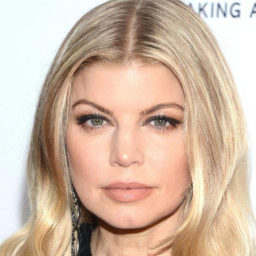

In [4]:
index = 13429
root = '/home/bastienvandelft/Datasets/CelebAMask-HQ/CelebA-HQ-img'
img_path = f"{root}/{index}.jpg"
X = PIL.Image.open(img_path)
transform = transform=transforms.Compose(
                        [transforms.Resize(256), 
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                            )
img_tensor = transform(X)
img_pil = transforms.functional.to_pil_image(img_tensor/2+0.5)
img_pil

In [11]:
number_of_sample = 1
shape = [number_of_sample, 3, 256, 256]
# random_seed = torch.randn(shape).to(device)
num_timesteps = int(ddpm.scheduler.betas.shape[0])
betas = ddpm.scheduler.betas
alphas = 1.0 - betas
alphas_cumprod = np.cumprod(alphas, axis=0)

In [12]:
def _extract_into_tensor(arr, timesteps, broadcast_shape):
    """
    Extract values from a 1-D numpy array for a batch of indices.
    :param arr: the 1-D numpy array.
    :param timesteps: a tensor of indices into the array to extract.
    :param broadcast_shape: a larger shape of K dimensions with the batch
                            dimension equal to the length of timesteps.
    :return: a tensor of shape [batch_size, 1, ...] where the shape has K dims.
    """
    try:
        res = torch.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    except:
        res = arr.to(device=timesteps.device)[timesteps].float()
    
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res.expand(broadcast_shape)


@torch.no_grad()
def langevin_sampling(inputs, model, t, t_prev, alphas_cumprod,alphas = alphas, steps = 100, epsilon = 1e-5,min_variance = 1e-4, 
                      device = device, denoising_step = True, clip_prev = False, clip_now = False, dynamic_thresholding = False,  
                      power  = 0.5, clip_inputs = True):
    timestep = t
    # print("timestep",timestep)
    index = t
    t = torch.tensor([t] * inputs.shape[0], device=device)  
    mean_coef_t = torch.sqrt(_extract_into_tensor(alphas_cumprod, t , inputs.shape))
    variance = _extract_into_tensor(1.0 - alphas_cumprod, t , inputs.shape)
    alphas = alphas.to(device)
    std = torch.sqrt(variance)
    std_epsilon = []
    mean_epsilon = []
    if t_prev is not None:
        t_prev = torch.tensor([t_prev] * inputs.shape[0], device=device)        
        mean_coef_t_prev = torch.sqrt(_extract_into_tensor(alphas_cumprod, t_prev , inputs.shape))
        variance_t_prev = _extract_into_tensor(1.0 - alphas_cumprod, t_prev , inputs.shape)
        std_prev = torch.sqrt(variance_t_prev)
        if clip_inputs:
            inputs = _clip_inputs(inputs, t = index, number_of_stds = 2)
        noise_estimate_t_prev = model(inputs, t_prev)['sample']
        x0_t_1 = (inputs - std_prev * noise_estimate_t_prev)/mean_coef_t_prev
        if dynamic_thresholding:
            x0_t_1 = _threshold_sample(x0_t_1, 0.98, 1.3)
        if clip_prev:
            x0_t_1 = x0_t_1.clamp(-1,1)
        inputs = inputs + x0_t_1 * (mean_coef_t - mean_coef_t_prev)
    inputs = inputs.to(device)
    model = model.to(device)
    alpha_coef = torch.ones_like(variance) * epsilon
    with torch.no_grad():
        for i in range(steps):
            if clip_inputs:
                inputs = _clip_inputs(inputs, t = index, number_of_stds = 2)
            noise_estimate = model(inputs, t)['sample']
            if dynamic_thresholding:
                x0_t = (inputs - std * noise_estimate)/mean_coef_t
                x0_t = _threshold_sample(x0_t, 0.98, 1.3)
                noise_estimate = (inputs - mean_coef_t * x0_t) / std
            elif clip_now:
                x0_t = (inputs - std * noise_estimate)/mean_coef_t
                x0_t = x0_t.clamp(-1,1)
                noise_estimate = (inputs - mean_coef_t * x0_t) / std
            std_epsilon.append(noise_estimate[0].cpu().std().item())
            mean_epsilon.append(noise_estimate[0].cpu().mean().item())
            score = - noise_estimate / std
            noise = torch.randn(inputs.shape).to(device)
            if steps > 1:
                inputs = (inputs + alpha_coef * score) + torch.pow(2*alpha_coef, power) * noise
        if denoising_step:
            if clip_inputs:
                inputs = _clip_inputs(inputs, t = index, number_of_stds = 2)
            noise_estimate = model(inputs, t)['sample']
            score = - noise_estimate / std
            inputs = (inputs + alpha_coef * score) 
    return inputs, alpha_coef, std_epsilon, mean_epsilon
    

In [13]:
def _threshold_sample(sample: torch.FloatTensor, dynamic_thresholding_ratio: float, sample_max_value : float = 5/3) -> torch.FloatTensor:
    """
    "Dynamic thresholding: At each sampling step we set s to a certain percentile absolute pixel value in xt0 (the
    prediction of x_0 at timestep t), and if s > 1, then we threshold xt0 to the range [-s, s] and then divide by
    s. Dynamic thresholding pushes saturated pixels (those near -1 and 1) inwards, thereby actively preventing
    pixels from saturation at each step. We find that dynamic thresholding results in significantly better
    photorealism as well as better image-text alignment, especially when using very large guidance weights."

    https://arxiv.org/abs/2205.11487
    """
    dtype = sample.dtype
    batch_size, channels, *remaining_dims = sample.shape

    if dtype not in (torch.float32, torch.float64):
        sample = sample.float()  # upcast for quantile calculation, and clamp not implemented for cpu half

    # Flatten sample for doing quantile calculation along each image
    sample = sample.reshape(batch_size, channels * np.prod(remaining_dims))

    abs_sample = sample.abs()  # "a certain percentile absolute pixel value"

    s = torch.quantile(abs_sample, dynamic_thresholding_ratio, dim=1)
    s = torch.clamp(
        s, min=1, max=sample_max_value
    )  # When clamped to min=1, equivalent to standard clipping to [-1, 1]
    s = s.unsqueeze(1)  # (batch_size, 1) because clamp will broadcast along dim=0
    sample = torch.clamp(sample, -s, s) / s  # "we threshold xt0 to the range [-s, s] and then divide by s"

    sample = sample.reshape(batch_size, channels, *remaining_dims)
    sample = sample.to(dtype)

    return sample

In [14]:
def score_generation(inputs, model, steps, alphas_cumprod,alphas, epsilon, device, num_timesteps, number_of_scale = 10,
                     clip_prev = False, clip_now = False, dynamic_thresholding: bool = False):
    list_alpha_coef = []
    t_valid = list(range(99,1001,50))[::-1] + [80,60,40,20,0]#list(range(1,1000,100))[::-1]
    #[999,800,650,500,400,300,250,200,150,130,110,90,64,36,20,5,1]#,20,10,5]
    t_valid = [999,650,500,420,360,285,220,165,125,90,60,36,0]
    # t_valid = list(range(1000))
    t_min_var = torch.tensor([0], device=device)
    min_variance = _extract_into_tensor(1.0 - alphas_cumprod,t_min_var , [1]).item()
    print("min_variance",min_variance)
    list_of_evolution = []
    list_of_evolution.append(inputs[0].cpu())
    t_prev = None
    for t in tqdm(t_valid):
        inputs, alpha_coef, std_epsilon, mean_epsilon = langevin_sampling(inputs, model, t, t_prev, alphas_cumprod, steps = steps, epsilon = epsilon,
                                                                         clip_prev = clip_prev, clip_now = clip_now, dynamic_thresholding = dynamic_thresholding,  min_variance = min_variance, device = device)
        
        if t % 1 ==0:
            list_of_evolution.append(inputs[0].cpu())
            list_alpha_coef.append(alpha_coef.cpu().mean().item())
            plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
            plt.show()
        t_prev = t
    plt.figure(figsize=[30,30])
    plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
    plt.show()
    plt.plot(np.array(list_alpha_coef))
    plt.show()
    return list_of_evolution

In [15]:
# list_of_evolution = score_generation(random_seed,  ddpm.unet, 100, alphas_cumprod,alphas = alphas,epsilon = 3e-5, device = device,num_timesteps = ddpm.scheduler.betas.shape[0],clip_prev = False,clip_now = False, dynamic_thresholding = True)

In [16]:
@torch.no_grad()
def _clip_inputs(sample: torch.FloatTensor, t : int, number_of_stds: float = 2., original_img = None):
    """
    Cliping the inputs with an confidence interval given by the diffusion schedule
    """
    dtype = sample.dtype
    batch_size, channels, *remaining_dims = sample.shape

    if dtype not in (torch.float32, torch.float64):
        sample = sample.float()  # upcast for quantile calculation, and clamp not implemented for cpu half
    alpha_t = alphas_cumprod[t]
    sqrt_alpha_t = torch.sqrt(alpha_t).item()
    one_minus_sqrt_alpha_t = torch.sqrt(1-alpha_t).item()
    if original_img is None:
        confidence_interval = [-sqrt_alpha_t - number_of_stds * one_minus_sqrt_alpha_t, sqrt_alpha_t + number_of_stds * one_minus_sqrt_alpha_t]
    else:
        confidence_interval = [sqrt_alpha_t * original_img - number_of_stds * one_minus_sqrt_alpha_t, 
                               sqrt_alpha_t * original_img + number_of_stds * one_minus_sqrt_alpha_t]
  
    sample = torch.clamp(sample, confidence_interval[0], confidence_interval[1])
    sample = sample.to(dtype)

    return sample

In [17]:
@torch.no_grad()
def ddim_step(inputs, model, t, alphas_cumprod = alphas_cumprod, clip_denoised = False, dynamic_thresholding = True, 
              clip_value = 1, sigma = 0, 
              number_of_timesteps = ddpm.scheduler.betas.shape[0], device = device, 
              forward = True, clip_inputs = True, number_of_stds = 2,
            prev_pred = None):
    
    index = t
    model = model.to(device)
    if len(inputs.shape) < 4 :
        inputs = inputs.unsqueeze(0)
    if t > 0 and forward:
        t_prev = torch.tensor([t-1] * inputs.shape[0], device=device)
        variance_prev = _extract_into_tensor(1.0 - alphas_cumprod, t_prev , inputs.shape)
        std_prev = torch.sqrt(variance_prev)
    elif t < number_of_timesteps :
        t_prev = torch.tensor([t+1] * inputs.shape[0], device=device)
        variance_prev = _extract_into_tensor(1.0 - alphas_cumprod, t_prev , inputs.shape)
        std_prev = torch.sqrt(variance_prev)
        
    t = torch.tensor([t] * inputs.shape[0], device=device)
    variance = _extract_into_tensor(1.0 - alphas_cumprod, t , inputs.shape)
    mean_coef_t = torch.sqrt(_extract_into_tensor(alphas_cumprod, t , inputs.shape))
    std = torch.sqrt(variance)
    if clip_inputs:
        if prev_pred is None:
            inputs = _clip_inputs(inputs, t = index, number_of_stds = number_of_stds)
        else:
            inputs = _clip_inputs(inputs, t = index, number_of_stds = number_of_stds, original_img = prev_pred)
    noise_estimate = model(inputs, t)['sample']
    std_epsilon = noise_estimate[0].cpu().std().item()
    mean_epsilon = noise_estimate[0].cpu().mean().item()
    if dynamic_thresholding:
        x0_t = (inputs - std * noise_estimate)/mean_coef_t
        x0_t = _threshold_sample(x0_t, 0.98, 1.3)
        noise_estimate = (inputs - mean_coef_t * x0_t) / std
        std_epsilon = noise_estimate[0].cpu().std().item()
        mean_epsilon = noise_estimate[0].cpu().mean().item()
    elif clip_denoised:
        x0_t = (inputs - std * noise_estimate)/mean_coef_t
        x0_t = x0_t.clamp(-1,1)
        noise_estimate = (inputs - mean_coef_t * x0_t) / std
        std_epsilon = noise_estimate[0].cpu().std().item()
        mean_epsilon = noise_estimate[0].cpu().mean().item()
    if sigma > 0:
        sigma_t = sigma * torch.sqrt((variance_prev)/(variance)) * torch.sqrt(1 - (1-variance)/ (1-variance_prev))
    else:
        sigma_t = 0.
    noise= torch.randn_like(inputs)
    x0_t = (inputs - std * noise_estimate)/mean_coef_t
    x_prev = torch.sqrt(1-variance_prev) / torch.sqrt(1-variance) * ((inputs - std * noise_estimate)) + torch.sqrt(variance_prev - sigma_t**2)  * noise_estimate + sigma_t * noise
    return x_prev, std_epsilon, mean_epsilon, x0_t

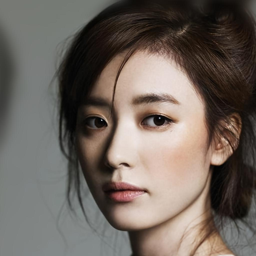

In [18]:
img_path = f"{root}/{20757}.jpg"
img_pil = PIL.Image.open(img_path).resize([256,256])
img_pil

In [19]:
def corrupt(number = [9999],corruption = 'spatter', random_sampling = False, random_corruption = False):
    corruptions_functions = {"shot_noise" : shot_noise, "gaussian_blur" : gaussian_blur, "spatter" : spatter, "fog":fog, "frost":frost, 
                        "snow":snow, "glass_blur":glass_blur, "elastic_transform":elastic_transform, "contrast":contrast, "brightness":brightness,
                        "gaussian_noise":gaussian_noise, "impulse_noise":impulse_noise, "masking_random_color_random":masking_random_color_random,
                        "motion_blur":motion_blur,"jpeg_compression":jpeg_compression, "pixelate":pixelate, 'saturate':saturate,
                        "masking_vhline_random_color":masking_hline_random_color, "masking_vline_random_color":masking_vline_random_color}
    if random_corruption:         
        corruption = random.choice(list(corruptions_functions.keys()))
    if random_sampling:
        number = np.random.randint(1,29999)
        img_path = f"{root}/{number}.jpg"
        img_pil = PIL.Image.open(img_path).resize([256,256])
        corrupted_sample = PIL.Image.fromarray(corruptions_functions[corruption](img_pil, severity  = 5).astype(np.uint8))
        img_tensor = (torch.from_numpy(np.array(corrupted_sample)).permute(2,0,1)/255).unsqueeze(0)*2-1
        original = (torch.from_numpy(np.array(img_pil)).permute(2,0,1)/255).unsqueeze(0)*2-1

    else:
        for index , n in enumerate(number):
            img_path = f"{root}/{n}.jpg"
            img_pil = PIL.Image.open(img_path).resize([256,256])
            corrupted_sample = PIL.Image.fromarray(corruptions_functions[corruption](img_pil, severity  = 5).astype(np.uint8))
            if index == 0:
                img_tensor = (torch.from_numpy(np.array(corrupted_sample)).permute(2,0,1)/255).unsqueeze(0)*2-1
                original = (torch.from_numpy(np.array(img_pil)).permute(2,0,1)/255).unsqueeze(0)*2-1
            else:
                img_tensor = torch.cat([img_tensor, (torch.from_numpy(np.array(corrupted_sample)).permute(2,0,1)/255).unsqueeze(0)*2-1])
                original = torch.cat([original,(torch.from_numpy(np.array(img_pil)).permute(2,0,1)/255).unsqueeze(0)*2-1])

    return img_tensor, original



In [43]:
dynamic_threshol_ratio = 0.98
dynamic_threshold_max = 1.3

@torch.no_grad()
def langevin_sampling(inputs, model, t, t_prev, steps = 100, epsilon = 1e-5,min_variance = -1, 
                     denoising_step = True, clip_prev = False, clip_now = False, dynamic_thresholding = False,  power  = 0.5,
                     clip_inputs = True, number_of_stds = 2, prev_pred = None):


    alphas_cumprod = ddpm.scheduler.alphas_cumprod.cpu().numpy()
    index = t
    t = torch.tensor([t] * inputs.shape[0]).to(device)   
    mean_coef_t = torch.sqrt(_extract_into_tensor(alphas_cumprod, t , inputs.shape))
    variance = _extract_into_tensor(1.0 - alphas_cumprod, t , inputs.shape)
    std = torch.sqrt(variance)
    std_epsilon = []
    mean_epsilon = []
    if t_prev is not None:
        t_prev = torch.tensor([t_prev] * inputs.shape[0]).to(device)     
        mean_coef_t_prev = torch.sqrt(_extract_into_tensor(alphas_cumprod, t_prev , inputs.shape))
        variance_t_prev = _extract_into_tensor(1.0 - alphas_cumprod, t_prev , inputs.shape)
        std_prev = torch.sqrt(variance_t_prev)
        if clip_inputs:
            inputs = _clip_inputs(inputs, t = index, number_of_stds = number_of_stds, original_img = prev_pred)
        noise_estimate_t_prev = model(inputs, t_prev)['sample']
        x0_t_1 = (inputs - std_prev * noise_estimate_t_prev)/mean_coef_t_prev
        if dynamic_thresholding:
            x0_t_1 = _threshold_sample(x0_t_1, dynamic_threshol_ratio, dynamic_threshold_max)
        if clip_prev:
            x0_t_1 = x0_t_1.clamp(-1,1)
        inputs = inputs + x0_t_1 * (mean_coef_t - mean_coef_t_prev)

    if min_variance > 0:
        alpha_coef =  (variance/min_variance) * epsilon
    else:
        alpha_coef = torch.ones_like(variance) * epsilon
    with torch.no_grad():
        for i in range(steps):
            if clip_inputs:
                inputs = _clip_inputs(inputs, t = index, number_of_stds = number_of_stds,original_img = prev_pred)
            noise_estimate = model(inputs, t)['sample']
            if dynamic_thresholding:
                x0_t = (inputs - std * noise_estimate)/mean_coef_t
                x0_t = _threshold_sample(x0_t, dynamic_threshol_ratio, dynamic_threshold_max)
                noise_estimate = (inputs - mean_coef_t * x0_t) / std
            elif clip_now:
                x0_t = (inputs - std * noise_estimate)/mean_coef_t
                x0_t = x0_t.clamp(-1,1)
                noise_estimate = (inputs - mean_coef_t * x0_t) / std
            std_epsilon.append(noise_estimate[0].cpu().std().item())
            mean_epsilon.append(noise_estimate[0].cpu().mean().item())
            score = - noise_estimate / std
            noise = torch.randn(inputs.shape).to(device)
            if steps > 1:
                inputs = (inputs + alpha_coef * score) + torch.pow(2*alpha_coef, power) * noise
        if denoising_step:
            if clip_inputs:
                inputs = _clip_inputs(inputs, t = index, number_of_stds = number_of_stds, original_img = prev_pred)
            noise_estimate = model(inputs, t)['sample']
            score = - noise_estimate / std
            inputs = (inputs + alpha_coef * score) 
        x0_t = (inputs - std * noise_estimate)/mean_coef_t
    return inputs, alpha_coef, std_epsilon, mean_epsilon, x0_t

In [78]:
def editing_with_ode(latent_codes, model, t_start = 1000, annealing = 1, epsilon = 1e-8, 
                    steps = 20, power =0.5, min_variance = -1. , number_of_sample = 1,normalize=False,
                    corrector_step = 1, comparison = False, clip_inputs = True, number_of_stds = 3, prev_pred = None, 
                    dynamic_thresholding_ddim = True,dynamic_thresholding_langevin = False ):
    
    alphas_cumprod = ddpm.scheduler.alphas_cumprod
    list_of_evolution_reverse = []
    final_samples = []
    t_valid = list(range(0, min(1000,t_start)))
    std_recon = 1
    epsilon = epsilon
    if t_start > 99 + corrector_step and corrector_step > 1:
        correction_latents = np.linspace(99, np.max(t_valid), corrector_step).astype(int).tolist()
        epsilon_correction = np.geomspace(1,100,1000)[::-1] 
        epsilon_correction = epsilon_correction / epsilon_correction[np.max(t_valid)]
    else:
        correction_latents = [np.max(t_valid)]
    print(f"correction_latents {correction_latents}")
    with torch.no_grad():
        if normalize:
            inputs = (latent_codes[np.max(t_valid)] - latent_codes[np.max(t_valid)].mean([1,2,3]))/latent_codes[np.max(t_valid)].std([1,2,3])
        else:
            inputs = latent_codes[np.max(t_valid)]
        if len(inputs.shape) == 3:
            inputs = inputs.unsqueeze(0)
            batch_size = 1
        elif len(inputs.shape) == 4:
            batch_size = inputs.shape[0]
        else:
            raise NotImplementedError

        if batch_size > 1 and number_of_sample > 1:
            inputs = inputs.split(1, dim=0)
            inputs = [inp.repeat(number_of_sample, 1, 1, 1) for inp in inputs]
            inputs = torch.cat(inputs)
        if prev_pred is not None:
            prev_pred = prev_pred.split(1,dim=0)
            prev_pred = [inp.repeat(number_of_sample, 1, 1, 1) for inp in prev_pred]
            prev_pred = torch.cat(prev_pred)
        
        elif number_of_sample > 1:
            inputs = inputs.repeat(number_of_sample, 1, 1, 1)
        else:
            inputs = inputs
        x0_t = prev_pred
        inputs = inputs.to(device)

        edited_to_be_done = True
        if comparison:
            run_with_correction = [False, True]
        else:
            run_with_correction = [corrector_step>1]
        for corrector in run_with_correction:
            for t in tqdm(range(1,np.max(t_valid)+1)[::-1]):
                if t == np.max(t_valid) and edited_to_be_done:
                    before = inputs.cpu()
                    if annealing>1:
                        for j in range(int(annealing)):
                            step_per_epsilon = steps // len(range(int(annealing)))
                            inputs,alpha_coef, list_of_stds, list_of_means, x0_t = langevin_sampling(inputs, model, t, 
                                                                                    None, steps = step_per_epsilon, epsilon = epsilon,
                                                                                    min_variance = min_variance, clip_prev = False, 
                                                                                    clip_now = False,dynamic_thresholding=dynamic_thresholding_langevin,
                                                                                    clip_inputs = clip_inputs, number_of_stds = number_of_stds, 
                                                                                    power = power,prev_pred = x0_t)
                            epsilon  = epsilon / 2

                    else:
                        inputs,alpha_coef, list_of_stds, list_of_means, x0_t = langevin_sampling(inputs, model, t, 
                                                                    None, steps = steps, epsilon = epsilon,
                                                                    min_variance = min_variance, clip_prev = False, 
                                                                    clip_now = False,dynamic_thresholding=dynamic_thresholding_langevin, 
                                                                    clip_inputs = clip_inputs, number_of_stds = number_of_stds,     
                                                                    power = power, prev_pred = x0_t)  
                    std_recon = list_of_stds[-1]
                    for h in range(len(inputs)):
                            list_of_evolution_reverse.append(inputs[h].cpu())
                    edited_latents = inputs
                    edited_to_be_done = False
                
                elif t == np.max(t_valid):
                    inputs = edited_latents

                elif t in correction_latents and corrector:
                    before = inputs.cpu()
                    new_epsilon = epsilon * epsilon_correction[t]
                    print(f'at {t} epsilon before {epsilon}, epsilon after {new_epsilon}')
                    if annealing>1:
                        for j in range(int(annealing)):
                            step_per_epsilon = steps // len(range(int(annealing)))
                            inputs,alpha_coef, list_of_stds, list_of_means, x0_t = langevin_sampling(inputs,model,  t, 
                                                                    None, steps = step_per_epsilon, epsilon = new_epsilon,
                                                                    min_variance = min_variance, clip_prev = False, 
                                                                    clip_now = False,dynamic_thresholding=dynamic_thresholding_langevin,
                                                                    clip_inputs = clip_inputs, number_of_stds = number_of_stds,
                                                                    power = power)
                            new_epsilon  = new_epsilon / 2
                    else:
                        inputs,alpha_coef, list_of_stds, list_of_means, x0_t = langevin_sampling(inputs,model,  t, 
                                                                        None, steps = steps, epsilon = new_epsilon,
                                                                        min_variance = min_variance, clip_prev = False, 
                                                                        clip_now = False,dynamic_thresholding=dynamic_thresholding_langevin, 
                                                                        clip_inputs = clip_inputs, number_of_stds = number_of_stds,
                                                                        power = power)  
                    std_recon = list_of_stds[-1]
                    for h in range(len(inputs)):
                            list_of_evolution_reverse.append(inputs[h].cpu())

                
                inputs, std_epsilon, mean_epsilon, x0_t = ddim_step(inputs, ddpm.unet, t, sigma = 0.,
                                                        clip_denoised=False,dynamic_thresholding=dynamic_thresholding_ddim,  forward=True, 
                                                        number_of_sample = number_of_sample,
                                                        clip_inputs = clip_inputs, number_of_stds = number_of_stds,prev_pred = x0_t)
                
                if prev_pred is None:
                    x0_t = None
                    
                std_recon = std_epsilon
                for h in range(len(inputs)):
                    list_of_evolution_reverse.append(inputs[h].cpu())
            for sample in list_of_evolution_reverse[-batch_size*number_of_sample:]:
                final_samples.append(sample)
                
        for h in range(len(inputs)):
            list_of_evolution_reverse.append(inputs[h].cpu())
    return list_of_evolution_reverse, final_samples


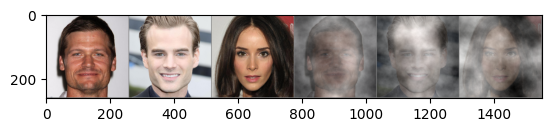

In [22]:
img_tensor, original = corrupt(number = [9992,9998, 9999],corruption = "fog", random_sampling=False)
plt.imshow(make_grid(torch.cat([original,img_tensor])).permute(1,2,0).cpu()/2+0.5)
plt.show()

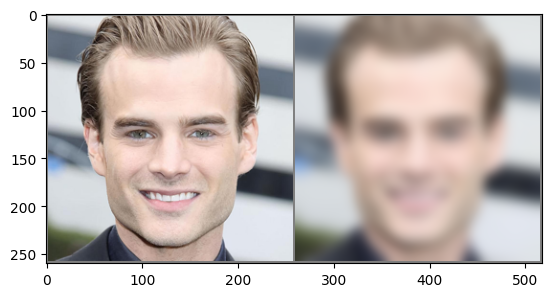

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


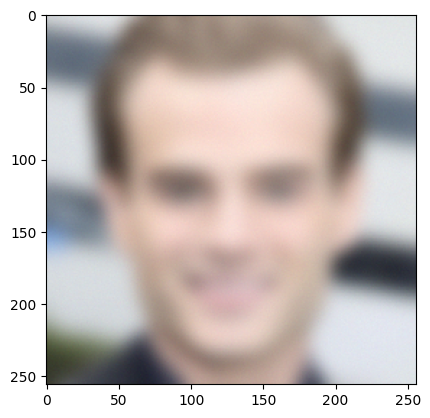

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


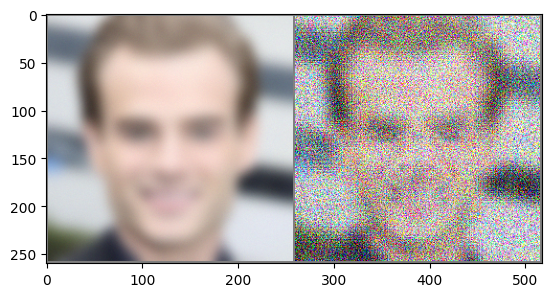

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


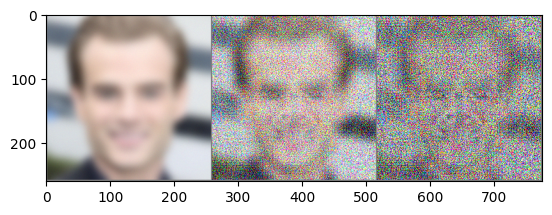

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


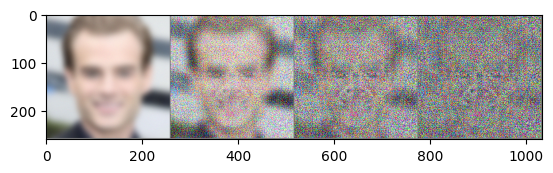

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


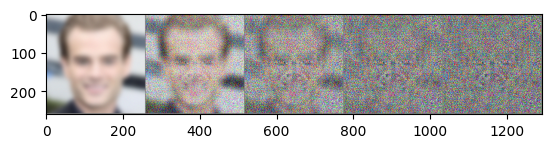

In [74]:
img_tensor, original = corrupt(number = [9998],corruption = "fog", random_sampling=False)
img_path = f"/home/bastienvandelft/corrupted/gaussian_blur/9998.png"
img_pil = PIL.Image.open(img_path).resize([256,256])
img_tensor = (torch.from_numpy(np.array(img_pil)).permute(2,0,1)/255).unsqueeze(0)*2-1
plt.imshow(make_grid(torch.cat([original,img_tensor])).permute(1,2,0).cpu()/2+0.5)
plt.show()
dynamic_threshol_ratio = 0.98
dynamic_threshold_max = 1.3
# img_tensor = sample.to(device)
for i in ['noisified']:
    if i == 'original':
        inputs = img_tensor.squeeze().to(device) #+ 0.01 * torch.randn_like(img_tensor).to(device)
    else:
        inputs = img_tensor.squeeze().to(device) + 0.01 * torch.randn_like(img_tensor).to(device)
    list_of_evolution = []
    list_std_encoding = []
    list_mean_encoding = []

    latent_codes = []
    with torch.no_grad():
        latent_codes.append(inputs)
        x0_t = img_tensor.squeeze().to(device)
        for t in range(0,ddpm.scheduler.betas.shape[0]-1):
            inputs, std_eps, mean_eps, x0_t = ddim_step(inputs, ddpm.unet, t, alphas_cumprod, sigma = 0.,clip_denoised=False,
                                                  dynamic_thresholding = True, device = device, forward=False,
                                                  clip_inputs = False, number_of_stds = 2., prev_pred = None)
            latent_codes.append(inputs)
            list_std_encoding.append(std_eps)
            list_mean_encoding.append(mean_eps)
            if t % 200 ==0:
                for i in inputs:
                    list_of_evolution.append(i.cpu())
                plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
                plt.show()
        for i in inputs:
            list_of_evolution.append(i.cpu())

In [ ]:
# latent_code = inputs
decoded_latents = []
inputs = latent_codes[-1].to(device)
# inputs = (inputs - inputs.mean([1,2,3], keepdim=True) )/ inputs.std([1,2,3], keepdim=True)
list_of_evolution = [i for i in latent_codes[0].cpu()]
with torch.no_grad():
    decoded_latents.append(inputs)
    # inputs = (inputs - inputs.mean([1,2,3], keepdim=True))/ inputs.std([1,2,3], keepdim=True)
    for i in inputs:
        list_of_evolution.append(i.cpu())
    plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
    plt.show()
    inputs = inputs.repeat(4, 1, 1, 1)
    for t in tqdm(list(range(0,ddpm.scheduler.betas.shape[0]-1))[::-1]):
        
        inputs, std_eps, mean_eps, x0_t = ddim_step(inputs, ddpm.unet, t, alphas_cumprod,clip_denoised=False,dynamic_thresholding=True, 
                                              sigma = 0., device = device,clip_inputs = False, number_of_stds = 3., forward=True,
                                              prev_pred = None)

        decoded_latents.append(inputs)
        if t % 200 == 0:
            for i in inputs:
                list_of_evolution.append(i.cpu())
            plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
            plt.show()
    for i in inputs:
        list_of_evolution.append(i.cpu())
    
plt.figure(figsize=[30,30])
plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
plt.show()

In [81]:
dynamic_threshol_ratio = 0.98
dynamic_threshold_max = 1.3
list_of_evolution_reverse, samples = editing_with_ode(latent_codes, ddpm.unet, t_start = 100, epsilon = 1e-3, steps = 600, power =0.5, 
                     number_of_sample = 4, annealing = 1, corrector_step = 1, comparison = False, clip_inputs = False, 
                     number_of_stds = 3, prev_pred = None, dynamic_thresholding_langevin = False, 
                     dynamic_thresholding_ddim = True)



correction_latents [99]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [01:38<00:00,  1.01it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


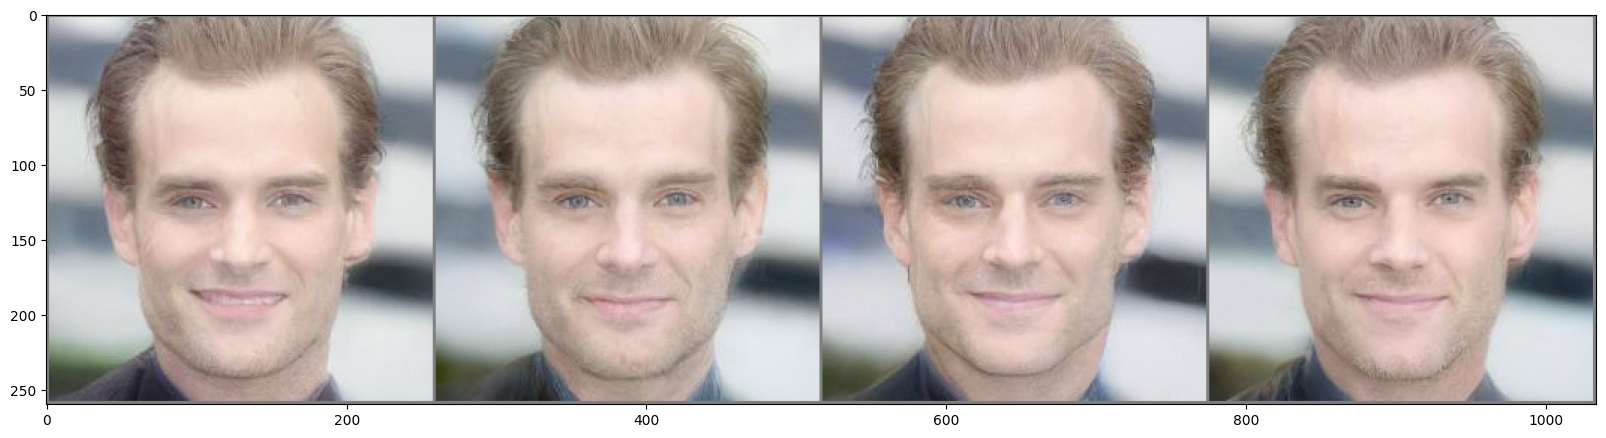

In [82]:
plt.figure(figsize=[20,20])
plt.imshow(make_grid(torch.stack(list_of_evolution_reverse[-4:]).cpu()).permute(1,2,0).cpu()/2+0.5)
plt.show() 

In [76]:
def editing_with_ode_comparison_steps(latent_codes, model, t_start = 1000, steps = 1000, save_every_langevin_steps= 200, annealing = 5,
                                      annealing_cst = 0.75, epsilon = 1e-4, 
                                      power =0.5, number_of_sample = 2,normalize=False,
                                      clip_inputs = False, number_of_stds = 3, prev_pred = None, 
                                      dynamic_thresholding_ddim = True,dynamic_thresholding_langevin = False):
    
    alphas_cumprod = ddpm.scheduler.alphas_cumprod
    list_of_evolution_reverse = []
    final_samples = []
    t_valid = list(range(0, min(1000,t_start)))
    std_recon = 1
    epsilon = epsilon
    correction_latents = [np.max(t_valid)]
    latents = {}
    print(f"correction_latents {correction_latents}")
    model = model.to(device)
    with torch.no_grad():
        if normalize:
            inputs = (latent_codes[np.max(t_valid)] - latent_codes[np.max(t_valid)].mean([1,2,3]))/latent_codes[np.max(t_valid)].std([1,2,3])
        else:
            inputs = latent_codes[np.max(t_valid)]
        if len(inputs.shape) == 3:
            inputs = inputs.unsqueeze(0)
            batch_size = 1
        elif len(inputs.shape) == 4:
            batch_size = inputs.shape[0]
        else:
            raise NotImplementedError

        if batch_size > 1 and number_of_sample > 1:
            inputs = inputs.split(1, dim=0)
            inputs = [inp.repeat(number_of_sample, 1, 1, 1) for inp in inputs]
            inputs = torch.cat(inputs)
        if prev_pred is not None:
            prev_pred = prev_pred.split(1,dim=0)
            prev_pred = [inp.repeat(number_of_sample, 1, 1, 1) for inp in prev_pred]
            prev_pred = torch.cat(prev_pred)
        
        elif number_of_sample > 1:
            inputs = inputs.repeat(number_of_sample, 1, 1, 1)
        else:
            inputs = inputs
        x0_t = prev_pred
        inputs = inputs.to(device)
        
        for t in tqdm(range(1,np.max(t_valid)+1)[::-1]):
            if t == np.max(t_valid):
                print("Let's go LANGEVIN")
                before = inputs.cpu()
                list_of_latents_to_recompose = []
                if annealing>1:
                    new_epsilon = epsilon
                    steps_per_epsilon = save_every_langevin_steps
                    print("steps_per_epsilon",steps_per_epsilon)
                    # number_of_annealing_steps = steps//save_every_langevin_steps+int(steps%save_every_langevin_steps>0)
                    
                    for j in range(int(annealing)):
                        list_of_latents_to_recompose.append(inputs)
                        print("new_epsilon",new_epsilon)
                        inputs,_, _, _, x0_t = langevin_sampling(inputs,model , t, 
                                                                None, steps = steps_per_epsilon, epsilon = new_epsilon,
                                                                min_variance = -1, clip_prev = False, 
                                                                clip_now = False,dynamic_thresholding=dynamic_thresholding_langevin,
                                                                clip_inputs = clip_inputs, number_of_stds = number_of_stds, 
                                                                power = power,prev_pred = None)
                        new_epsilon  = new_epsilon * annealing_cst
                        latents[j] = inputs
                    list_of_latents_to_recompose.append(inputs)
                    print(len(list_of_latents_to_recompose))
                    latents_to_recompose = torch.cat(list_of_latents_to_recompose, dim=0)
                    

                else:
                    list_of_latents_to_recompose = []
                    number_of_saving_steps = steps//save_every_langevin_steps+int(steps%save_every_langevin_steps>0)
                    ## TO DO save at different steps
                    
                    for j in tqdm(range(number_of_saving_steps)):
                        list_of_latents_to_recompose.append(inputs)
                        inputs,_, _, _, x0_t = langevin_sampling(inputs,model, t, 
                                                                None, steps = save_every_langevin_steps, epsilon = epsilon,
                                                                min_variance = -1, clip_prev = False, 
                                                                clip_now = False,dynamic_thresholding=dynamic_thresholding_langevin, 
                                                                clip_inputs = clip_inputs, number_of_stds = number_of_stds,     
                                                                power = power, prev_pred = None)  
                        print(len(list_of_latents_to_recompose))
                        
                    list_of_latents_to_recompose.append(inputs)
                    print(len(list_of_latents_to_recompose))
                    latents_to_recompose = torch.cat(list_of_latents_to_recompose, dim=0)
                
                for h in range(len(inputs)):
                        list_of_evolution_reverse.append(inputs[h].cpu())
                

                inputs = latents_to_recompose
                
            elif t == 199:
                new_epsilon = 1e-2
                steps_per_epsilon = 100
                for j in range(5):
                    print("new_epsilon",new_epsilon)
                    inputs,_, _, _, _ = langevin_sampling(inputs,model , t, 
                                                            None, steps = steps_per_epsilon, epsilon = new_epsilon,
                                                            min_variance = -1, clip_prev = False, 
                                                            clip_now = False,dynamic_thresholding=dynamic_thresholding_langevin,
                                                            clip_inputs = clip_inputs, number_of_stds = number_of_stds, 
                                                            power = power,prev_pred = None)
                    new_epsilon  = new_epsilon * annealing_cst

                
            inputs, _, _, _ = ddim_step(inputs, model, t, sigma = 0.,
                                                    clip_denoised=False,dynamic_thresholding=dynamic_thresholding_ddim,  forward=True, 
                                                    number_of_sample = number_of_sample,
                                                    clip_inputs = clip_inputs, number_of_stds = number_of_stds,prev_pred = None)
            
            
            if prev_pred is None:
                x0_t = None
                
            
            # for h in range(len(inputs)):
            #     list_of_evolution_reverse.append(inputs[h].cpu())
        for sample in list_of_evolution_reverse[-batch_size*number_of_sample:]:
            final_samples.append(sample)
                
        for h in range(len(inputs)):
            list_of_evolution_reverse.append(inputs[h].cpu())
    return list_of_evolution_reverse, final_samples, inputs, latents


In [70]:
number_of_sample = 3
list_of_evolution_reverse, final_samples, inputs, latents = editing_with_ode_comparison_steps(latent_codes, ddpm.unet, epsilon = 1e-5, 
                                                                                     steps = 600,annealing_cst = 1,
                                                                                     save_every_langevin_steps= 150,power =0.5, 
                                                                                     number_of_sample = number_of_sample, annealing = 4, 
                                                                                     clip_inputs = False, 
                                                                                     number_of_stds = 3, prev_pred = None, 
                                                                                     dynamic_thresholding_langevin = True, 
                                                                                     dynamic_thresholding_ddim = True)

correction_latents [999]


  0%|                                                                                                                                                                                                          | 0/999 [00:00<?, ?it/s]

Let's go LANGEVIN
steps_per_epsilon 150
new_epsilon 1e-05
new_epsilon 1e-05
new_epsilon 1e-05
new_epsilon 1e-05
5


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 800/999 [07:19<01:35,  2.08it/s]

new_epsilon 0.01
new_epsilon 0.01
new_epsilon 0.01
new_epsilon 0.01
new_epsilon 0.01


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [13:06<00:00,  1.27it/s]


In [ ]:
plt.figure(figsize=[20,20])
plt.imshow(make_grid(inputs.cpu()).permute(1,2,0).cpu()/2+0.5)
plt.show() 

In [ ]:
liste = inputs.cpu().split(1)
liste_of_samples = []
for n in range(number_of_sample):
    liste_of_samples += [input for input in liste[n::number_of_sample]]

results = torch.cat(liste_of_samples)
plt.figure(figsize=[20,20])
plt.imshow(make_grid(results.cpu()).permute(1,2,0).cpu()/2+0.5)
plt.show() 

In [49]:
liste = inputs.cpu().split(1)
b = [input for input in liste[0::2]]
c = [input for input in liste[1::2]]
d = b + c
results = torch.cat(d)
results.shape

torch.Size([33, 3, 256, 256])

In [ ]:
plt.figure(figsize=[20,20])
plt.imshow(make_grid(results.cpu()).permute(1,2,0).cpu()/2+0.5)
plt.show() 

In [54]:
# old_results = results

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


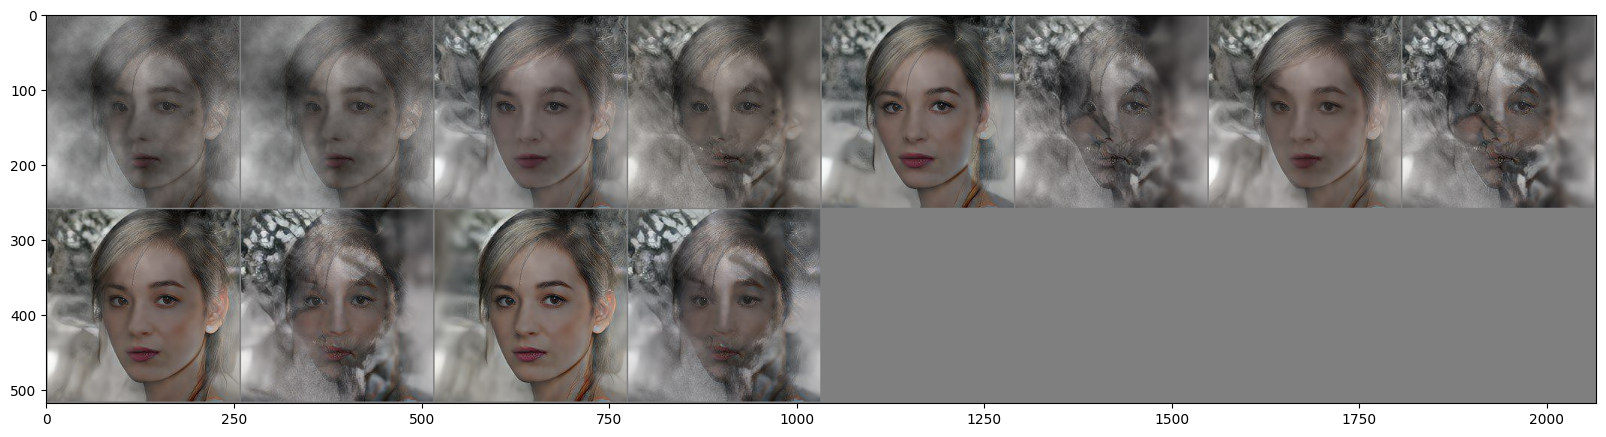

In [28]:
plt.figure(figsize=[20,20])
plt.imshow(make_grid(inputs.cpu()).permute(1,2,0).cpu()/2+0.5)
plt.show() 

t_start 1000
editing 999


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


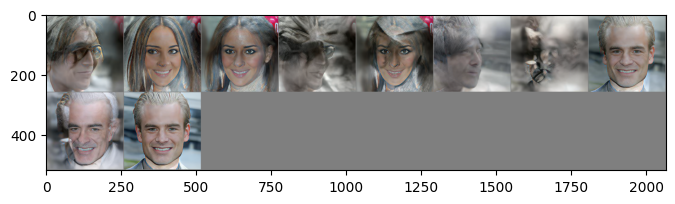

In [267]:
list_of_evolution_reverse, samples = editing_with_ode(latent_codes, ddpm.unet, t_start = 1000, std_div = -1, epsilon = 1e-5, steps = 1000, power =0.5, 
                     number_of_sample = 5, annealing = False, alphas_cumprod = alphas_cumprod, 
                    corrector_step = False, deep_correction=False, comparison = False)



In [ ]:
list_of_evolution_reverse, samples = editing_with_ode(latent_codes, ddpm.unet, t_start = 1000, std_div = -1, epsilon = 4e-5, steps = 1000, power =0.5, 
                     number_of_sample = 5, annealing = False, alphas_cumprod = alphas_cumprod, corrector_step = False, deep_correction=False, comparison = False)



In [ ]:
list_of_evolution_reverse, samples = editing_with_ode(latent_codes, ddpm.unet, t_start = 1000, std_div = -1, epsilon = 5e-5, steps = 1000, power =0.5, 
                     number_of_sample = 5, annealing = False, alphas_cumprod = alphas_cumprod, corrector_step = False, deep_correction=False, comparison = False)



In [ ]:
plt.figure(figsize=[20,20])
plt.imshow(make_grid(torch.cat([img_tensor.cpu() ,torch.stack(list_of_evolution_reverse[-20:]).cpu()])).permute(1,2,0).cpu()/2+0.5)
plt.show() 

In [44]:
torch.cat([img_tensor ,torch.stack(list_of_evolution_reverse[-8:])])

tensor([[[[ 0.5922, -0.1686, -0.9529,  ..., -0.5686,  0.6392,  0.5373],
          [ 0.5922, -0.1686, -0.9529,  ..., -0.5686,  0.6392,  0.5216],
          [ 0.5922, -0.1686, -0.9529,  ..., -0.5686,  0.6392,  0.5216],
          ...,
          [ 0.5686, -0.1686, -0.9529,  ..., -0.5686,  0.6392, -0.6392],
          [ 0.5686, -0.1686, -0.9529,  ..., -0.5686,  0.6392, -0.6627],
          [ 0.5765, -0.1686, -0.9529,  ..., -0.5686,  0.6392, -0.6784]],

         [[-0.2627,  0.6157,  0.5686,  ...,  0.5765, -0.5922, -0.2392],
          [-0.2627,  0.6157,  0.5686,  ...,  0.5765, -0.5922, -0.2392],
          [-0.2627,  0.6157,  0.5765,  ...,  0.5765, -0.5922, -0.2392],
          ...,
          [-0.2627,  0.6157,  0.5451,  ...,  0.5765, -0.5922, -0.2392],
          [-0.2627,  0.6157,  0.4510,  ...,  0.5765, -0.5922, -0.2392],
          [-0.2627,  0.6157,  0.4980,  ...,  0.5765, -0.5922, -0.2392]],

         [[ 0.5529, -0.4824,  0.0353,  ...,  0.4431, -0.0275,  0.4275],
          [ 0.5529, -0.4824,  

In [ ]:
# #### inputs = random_seed

# # img_tensor, original = corrupt(corruption = "gaussian_blur", random_sampling=False)
# def revert_ode(img_tensor, model):
stds_enc = {'original' : [], 'noisified' : []}
stds_dec = {'original' : [], 'noisified' : []}
means_enc = {'original' : [], 'noisified' : []}
means_dec = {'original' : [], 'noisified' : []}
for k in tqdm(range(100)):
    img_tensor, original = corrupt(corruption = "frost", random_sampling=True)
    for i in ['original', 'noisified']:
        if i == 'original':
            inputs = original.squeeze().unsqueeze(0).to(device) #+ 0.01 * torch.randn_like(img_tensor).to(device)
        else:
            inputs = original.squeeze().unsqueeze(0).to(device) + 0.01 * torch.randn_like(img_tensor).to(device)
        list_of_evolution = []
        list_std_encoding = []
        list_mean_encoding = []
        # steps = 100
        # epsilon = 1e-8
        # t_min_var = torch.tensor([1], device=device)
        # min_variance = _extract_into_tensor(1.0 - alphas_cumprod,t_min_var , [1]).item()
        latent_codes = []
        with torch.no_grad():
            latent_codes.append(inputs)
            for t in range(0,ddpm.scheduler.betas.shape[0]-1):
                inputs, std_eps, mean_eps = ddim_step(inputs, ddpm.unet, t, alphas_cumprod, sigma = 0.,clip_denoised=True,dynamic_thresholding = True, device = device, forward=False)
                latent_codes.append(inputs)
                list_std_encoding.append(std_eps)
                list_mean_encoding.append(mean_eps)
                # if t % 100 ==0:
                #     list_of_evolution.append(inputs[0].cpu())
                #     plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
                #     plt.show()
            list_of_evolution.append(inputs[0].cpu())
            
        plt.figure(figsize=[20,20])
        plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
        plt.show()
        latent_code = inputs
        inputs = latent_code.squeeze().unsqueeze(0).to(device)
        list_of_evolution = []
        list_std_decoding = []
        list_mean_decoding = []
        decoded_latents = []
        # steps = 100
        # epsilon = 1e-8
        t_min_var = torch.tensor([1], device=device)
        min_variance = _extract_into_tensor(1.0 - alphas_cumprod,t_min_var , [1]).item()
        with torch.no_grad():
            decoded_latents.append(inputs)
            for t in list(range(0,ddpm.scheduler.betas.shape[0]-1))[::-1]:
                inputs, std_eps, mean_eps = ddim_step(inputs, ddpm.unet, t, alphas_cumprod,clip_denoised=True,dynamic_thresholding=True, sigma = 0., device = device, forward=True)
                list_std_decoding.append(std_eps)
                list_mean_decoding.append(mean_eps)
                decoded_latents.append(inputs)
                # if t % 100 == 0:
                #     list_of_evolution.append(inputs[0].cpu())
                #     plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
                #     plt.show()
        
            list_of_evolution.append(inputs[0].cpu())
            
        plt.figure(figsize=[30,30])
        plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
        plt.show()
        stds_enc[i].append(np.array(list_std_encoding))
        stds_dec[i].append(np.array(list_std_decoding))
        means_enc[i].append(np.array(list_mean_encoding))
        means_dec[i].append(np.array(list_mean_decoding))
    # return latent_codes
# revert_ode(img_tensor, ddpm.unet)

In [ ]:
plt.plot(np.stack(stds_enc['original']).mean(0))

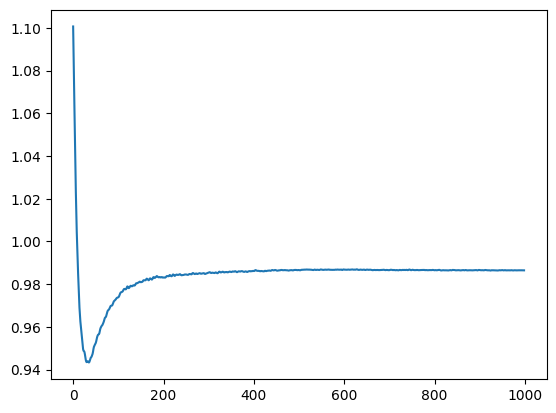

In [44]:
plt.plot(np.stack(stds_enc['noisified']).mean(0))

In [ ]:
if True:
    inputs = latent_code.squeeze().unsqueeze(0).to(device)
    list_of_evolution = []
    list_std_decoding = []
    list_mean_decoding = []
    decoded_latents = []
    # steps = 100
    # epsilon = 1e-8
    t_min_var = torch.tensor([1], device=device)
    min_variance = _extract_into_tensor(1.0 - alphas_cumprod,t_min_var , [1]).item()
    with torch.no_grad():
        decoded_latents.append(inputs)
        for t in list(range(0,ddpm.scheduler.betas.shape[0]-1))[::-1]:
            inputs, std_eps, mean_eps = ddim_step(inputs, ddpm.unet, t, alphas_cumprod,clip_denoised=True,dynamic_thresholding=True, sigma = 0., device = device, forward=True)
            list_std_decoding.append(std_eps)
            list_mean_decoding.append(mean_eps)
            decoded_latents.append(inputs)
            if t % 100 == 0:
                list_of_evolution.append(inputs[0].cpu())
                plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
                plt.show()
    
        list_of_evolution.append(inputs[0].cpu())
        
    plt.figure(figsize=[30,30])
    plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
    plt.show()

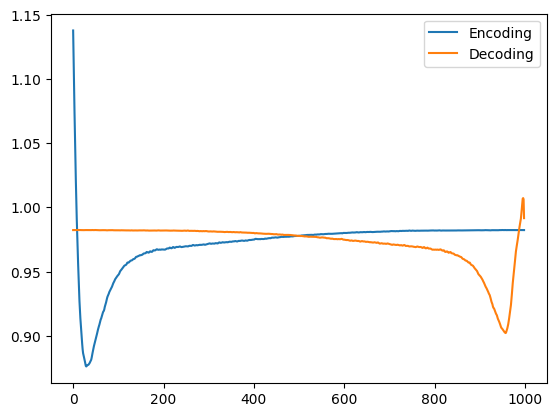

In [30]:
plt.plot(np.array(list_std_encoding), label="Encoding")
plt.plot(np.array(list_std_decoding), label="Decoding")
# plt.plot(np.array(list_std_decoding_rdn), label="Decoding_rdn")
# plt.plot(np.array(list_std_encoding_rdn), label="Encoding_rdn")
plt.legend()
plt.show()

In [25]:
if False:
    inputs = random_seed.squeeze().unsqueeze(0).to(device)
    list_of_evolution = []
    list_std_decoding_rdn = []
    list_mean_decoding_rdn = []
    # steps = 100
    # epsilon = 1e-8
    t_min_var = torch.tensor([1], device=device)
    min_variance = _extract_into_tensor(1.0 - alphas_cumprod,t_min_var , [1]).item()
    with torch.no_grad():
        for t in list(range(0,ddpm.scheduler.betas.shape[0]-1))[::-1]:
            inputs, std_eps, mean_eps = ddim_step(inputs, ddpm.unet, t, alphas_cumprod, sigma = 0., device = device, forward=True)
            list_std_decoding_rdn.append(std_eps)
            list_mean_decoding_rdn.append(mean_eps)
            if t % 100 ==0:
                list_of_evolution.append(inputs[0].cpu())
                plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
                plt.show()
        list_of_evolution.append(inputs[0].cpu())
    
    list_std_encoding_rdn = []
    list_mean_encoding_rdn = []
    
    with torch.no_grad():
        for t in range(0,ddpm.scheduler.betas.shape[0]-1):
            inputs, std_eps, mean_eps = ddim_step(inputs, ddpm.unet, t, alphas_cumprod, sigma = 0., device = device, forward=False)
            list_std_encoding_rdn.append(std_eps)
            list_mean_encoding_rdn.append(mean_eps)
            if t % 100 ==0:
                list_of_evolution.append(inputs[0].cpu())
                plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
                plt.show()
        list_of_evolution.append(inputs[0].cpu())
# plt.figure(figsize=[20,20])
# plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
# plt.show()

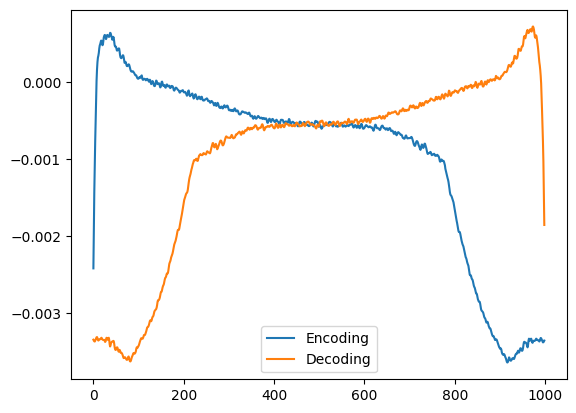

In [26]:
plt.plot(np.array(list_mean_encoding), label="Encoding")
plt.plot(np.array(list_mean_decoding), label="Decoding")
# plt.plot(np.array(list_mean_decoding_rdn), label="Decoding_rdn")
# plt.plot(np.array(list_mean_encoding_rdn), label="Encoding_rdn")
plt.legend()
plt.show()

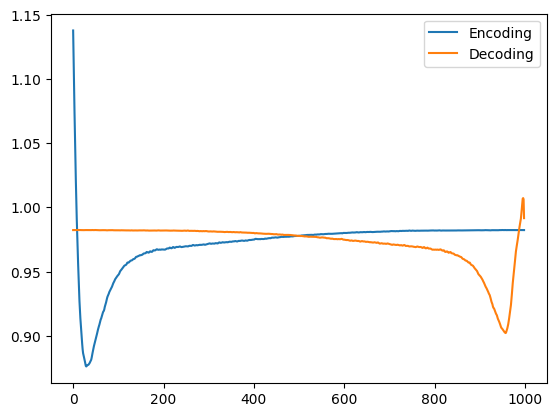

In [31]:
plt.plot(np.array(list_std_encoding), label="Encoding")
plt.plot(np.array(list_std_decoding), label="Decoding")
# plt.plot(np.array(list_std_decoding_rdn), label="Decoding_rdn")
# plt.plot(np.array(list_std_encoding_rdn), label="Encoding_rdn")
plt.legend()
plt.show()

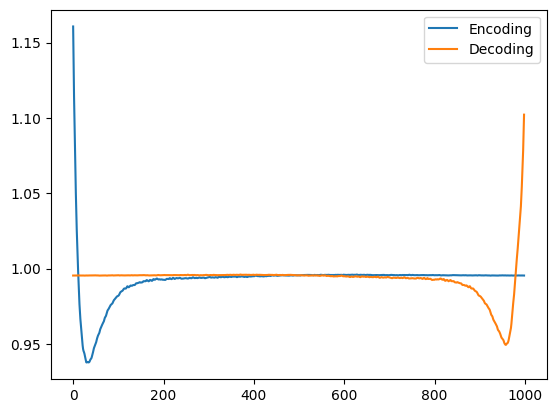

In [27]:
plt.plot(np.array(list_std_encoding), label="Encoding")
plt.plot(np.array(list_std_decoding), label="Decoding")
# plt.plot(np.array(list_std_decoding_rdn), label="Decoding_rdn")
# plt.plot(np.array(list_std_encoding_rdn), label="Encoding_rdn")
plt.legend()
plt.show()

In [ ]:
def compute_psnr(image_true, image_test, data_range=1):
  # this function is based on skimage.metrics.peak_signal_noise_ratio
  err = np.mean((image_true - image_test) ** 2, dtype=np.float64) 
  return 10 * np.log10((data_range ** 2) / err)

In [20]:
def extract(a, t, x_shape):
    """Extract coefficients from a based on t and reshape to make it
    broadcastable with x_shape."""
    bs, = t.shape
    assert x_shape[0] == bs
    out = torch.gather(torch.tensor(a, dtype=torch.float, device=t.device), 0, t.long())
    assert out.shape == (bs,)
    out = out.reshape((bs,) + (1,) * (len(x_shape) - 1))
    return out


def image_editing_denoising_step_flexible_mask(x, t, *,
                                               model,
                                               logvar,
                                               betas):
    """
    Sample from p(x_{t-1} | x_t)
    """
    alphas = 1.0 - betas
    alphas_cumprod = alphas.cumprod(dim=0)

    model_output = model(x, t)[0]
    weighted_score = betas / torch.sqrt(1 - alphas_cumprod)
    mean = extract(1 / torch.sqrt(alphas), t, x.shape) * (x - extract(weighted_score, t, x.shape) * model_output)

    logvar = extract(logvar, t, x.shape)
    noise = torch.randn_like(x)
    mask = 1 - (t == 0).float()
    mask = mask.reshape((x.shape[0],) + (1,) * (len(x.shape) - 1))
    sample = mean + mask * torch.exp(0.5 * logvar) * noise
    sample = sample.float()
    return sample


import warnings


warnings.filterwarnings("ignore")
device = "cuda:3"

def load_model(model_id = "google/ddpm-celebahq-256", device = 'cuda'):

    ddim = DDIMPipeline.from_pretrained(model_id)
    model = ddim.unet
    model = model.to(device)
    model.eval()
    scheduler = ddim.scheduler
    print("Model loaded")
    betas = ddim.scheduler.betas 
    num_timesteps = betas.shape[0]
    alphas = (1.0 - betas).numpy()
    alphas_cumprod = np.cumprod(alphas, axis=0)
    alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])
    posterior_variance = betas * \
        (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
    logvar = np.log(np.maximum(posterior_variance, 1e-20))

    return model, betas, num_timesteps, logvar


def imshow(img, title=""):
    img = img.to("cpu")
    img = img.permute(1, 2, 0, 3)
    img = img.reshape(img.shape[0], img.shape[1], -1)
    img = img / 2 + 0.5     # unnormalize
    img = torch.clamp(img, min=0., max=1.)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()


def SDEditing(img_tensor, betas, logvar, model, sample_step, total_noise_levels, n=4, device = 'cuda:3'):
    with torch.no_grad():
        # [mask, img] = torch.load("colab_demo/{}.pth".format(name))
        # img = PIL.Image.open("/mnt/scitas/bastien/CelebAMask-HQ/CelebA-HQ-img/1008.jpg").resize([256,256])
        # img = img.convert('RGB')
        # img = (torch.from_numpy(np.array(img))/255).permute(2,0,1)
        img = img_tensor.to(device)
        img = img_tensor / 2 + 0.5
        img = img.to(device)
        if len(img.shape) < 4:
            img = img.unsqueeze(dim=0)
            
            img = img.repeat(n, 1, 1, 1)
        else:
            img = img
        mask = torch.zeros_like(img[0])
        mask = mask.to(device)
        x0 = img
        x0 = (x0 - 0.5) * 2.
        # imshow(x0, title="Initial input")

        for it in range(sample_step):
            e = torch.randn_like(x0)
            a = (1 - betas).cumprod(dim=0).to(device)
            x = x0 * a[total_noise_levels - 1].sqrt() + e * (1.0 - a[total_noise_levels - 1]).sqrt()
            # imshow(x, title="Perturb with SDE")

            # with tqdm(total=total_noise_levels, desc="Iteration {}".format(it)) as progress_bar:
            for i in reversed(range(total_noise_levels)):
                # t = torch.ones_like(x) * i
                t = (torch.ones(x.shape[0]) * i).to(device)
                x_ = image_editing_denoising_step_flexible_mask(x, t=t, model=model,
                                                                logvar=logvar,
                                                                betas=betas)
                x = x0 * a[i].sqrt() + e * (1.0 - a[i]).sqrt()
                x[:, (mask != 1.)] = x_[:, (mask != 1.)]
                # added intermediate step vis
                # if (i - 99) % 100 == 0:
                #     imshow(x, title="Iteration {}, t={}".format(it, i))
                # progress_bar.update(1)

            x0[:, (mask != 1.)] = x[:, (mask != 1.)]
            # imshow(x)
    return x


# sample_step = 1
# list_enhanced_sde = {}
# model, betas, num_timesteps, logvar = load_model()
# for total_noise_levels in range(100,700,100):
#     for img in list_images:
#         new_img_tensor = img.to(device)
#         sde_enhanced = SDEditing(new_img_tensor,scheduler.betas, logvar, unet.to(device), sample_step, total_noise_levels, n=1)
#         list_enhanced_sde[total_noise_levels] = sde_enhanced

In [21]:
if False:
    import pickle
    import os
    dic_stds_eps_langevin = {}
    dic_mean_eps_langevin = {}
    dic_stds_eps_ddim = {}
    dic_mean_eps_ddim = {}
    dic_std_encoding = {}
    dic_mean_encoding = {}
    dic_distance_latent = {}
    dic_distances_source_odedit = {}
    dic_distances_target_odedit = {}
    dic_psnr_source_odedit = {}
    dic_psnr_target_odedit = {}
    dic_distances_source_sdedit = {}
    dic_distances_target_sdedit = {}
    dic_psnr_source_sdedit = {}
    dic_psnr_target_sdedit = {}
    dic_psnr_source_target = {}
    dic_distances_source_target = {}
    _ , _ , _ , logvar = load_model()
    starting_k = 299
    for t_valid in list(range(99,1000,100)):
        print(t_valid)
        os.makedirs(f'/mnt/scitas/bastien/results/corrupted_{t_valid}/', exist_ok=True)
        os.makedirs(f'/mnt/scitas/bastien/results/original_{t_valid}/', exist_ok=True)
        os.makedirs(f'/mnt/scitas/bastien/results/sde_{t_valid}/', exist_ok=True)
        os.makedirs(f'/mnt/scitas/bastien/results/ode_{t_valid}/', exist_ok=True)
        list_distances_source_target = []
        list_distances_source = []
        list_distances_target = []
        list_distances_source_sde = []
        list_distances_target_sde = []
        list_psnr_source = []
        list_psnr_target = []
        list_psnr_source_sde = []
        list_psnr_target_sde = []
        list_psnr_source_target = []
        stds_eps_langevin = []
        mean_eps_langevin = []
        for k in tqdm(range(300)):
            img_tensor, original = corrupt(random_sampling=True)
            while img_tensor.shape[1] != 256:
                print("wrong size")
                img_tensor, original = corrupt(random_sampling=True)
            inputs = img_tensor.squeeze().unsqueeze(0).to(device)
            save_image(inputs[0].cpu()/2+0.5, f'/mnt/scitas/bastien/results/corrupted_{t_valid}/{k+starting_k}.jpg')
            save_image(original.cpu()/2+0.5, f'/mnt/scitas/bastien/results/original_{t_valid}/{k+starting_k}.jpg')
            list_psnr_source_target.append(compute_psnr((original.squeeze().cpu()/2-0.5).numpy() , (img_tensor.squeeze().cpu()/2-0.5).numpy()))
            list_distances_source_target.append((((img_tensor.squeeze().cpu())-original.squeeze().cpu())**2).mean().item())
            list_std_encoding = []
            list_mean_encoding = []
            latent_codes = []
            with torch.no_grad():
                latent_codes.append(inputs)
                # for t in range(0,ddpm.scheduler.betas.shape[0]-1):
                for t in range(0,t_valid+1):
                    inputs, std_eps, mean_eps = ddim_step(inputs, ddpm.unet, t, alphas_cumprod, sigma = 0., device = device, forward=False)
                    latent_codes.append(inputs)
                    list_std_encoding.append(std_eps)
                    list_mean_encoding.append(mean_eps)
            array_std_encoding = np.expand_dims(np.array(list_std_encoding), axis=0)
            array_mean_encoding = np.expand_dims(np.array(list_mean_encoding), axis=0)
            if k > 0:
                std_encoding = np.concatenate((std_encoding,array_std_encoding))
                mean_encoding = np.concatenate((mean_encoding,array_mean_encoding))
            else:
                std_encoding = array_std_encoding
                mean_encoding = array_mean_encoding
    
            # ODEDIT
            std_recon = 0
            steps = 100
            min_variance = 1e-4
            epsilons = [5e-7]
            number_of_sample = 1
            power = 0.5
            list_of_std_eps_ddim = []
            list_of_mean_eps_ddim = []
            list_of_stds_eps_langevin = []
            list_of_mean_eps_langevin = []
            list_distances = []
            with torch.no_grad():
                inputs = latent_codes[t_valid].repeat(number_of_sample, 1,1,1)
                for epsilon in epsilons:
                    for t in range(1,t_valid+1)[::-1]:
                        # LANGEVIN UPDATES
                        if t == t_valid:
                            counter = 0
                            while std_recon < 0.95 or std_recon > 1.05 or counter == 0:
                            # while counter == 0:
                                inputs, alpha_coef, list_of_stds, list_of_means = langevin_sampling(inputs, ddpm.unet, t, t, alphas_cumprod, steps = steps, epsilon = epsilon,
                                                       min_variance = min_variance, clip_prev = False, clip_now = True, device = device, power = power)
                                list_of_stds_eps_langevin.append(np.array(list_of_stds))
                                list_of_mean_eps_langevin.append(np.array(list_of_means))
                                std_recon = list_of_stds[-1]
                                counter += 1
                                if counter > 10:
                                    epsilon = 10*epsilon
                                array_stds_eps_langevin = np.expand_dims(np.array(list_of_stds_eps_langevin), axis=0)
                                array_mean_eps_langevin = np.expand_dims(np.array(list_of_mean_eps_langevin), axis=0)
                                if k >= 0 :
                                    stds_eps_langevin.append((stds_eps_langevin, array_stds_eps_langevin))
                                    mean_eps_langevin.append((mean_eps_langevin, array_mean_eps_langevin))
        
                        list_distances.append((((latent_codes[t].repeat(number_of_sample, 1,1,1))-inputs)**2).mean().item())
                        # DDIM STEP
                        inputs, std_epsilon, mean_epsilon = ddim_step(inputs, ddpm.unet, t, alphas_cumprod, sigma = 0., device = device, forward=True, number_of_sample = number_of_sample)
                        list_of_std_eps_ddim.append(std_epsilon)
                        list_of_mean_eps_ddim.append(mean_epsilon)
        
                    save_image(inputs[0].cpu()/2+0.5, f'/mnt/scitas/bastien/results/ode_{t_valid}/{k+starting_k}.jpg')
                    list_distances_source.append((((img_tensor.squeeze().unsqueeze(0).repeat(number_of_sample, 1,1,1).cpu())-inputs.cpu())**2).mean().item())
                    list_distances_target.append((((original.squeeze().unsqueeze(0).repeat(number_of_sample, 1,1,1).cpu())-inputs.cpu())**2).mean().item())
        
                    list_psnr_source.append(compute_psnr((img_tensor.squeeze().cpu()/2-0.5).numpy() , (inputs.squeeze().cpu()/2-0.5).numpy()))
                    list_psnr_target.append(compute_psnr((original.squeeze().cpu()/2-0.5).numpy() , (inputs.squeeze().cpu()/2-0.5).numpy()))
                    
                    array_std_eps_ddim = np.expand_dims(np.array(list_of_std_eps_ddim), axis=0)
                    array_mean_eps_ddim = np.expand_dims(np.array(list_of_mean_eps_ddim), axis=0)
                    array_distances = np.expand_dims(np.array(list_distances), axis=0)
        
                    
                    if k > 0:
                        std_eps_ddim = np.concatenate((std_eps_ddim, array_std_eps_ddim))
                        mean_eps_ddim = np.concatenate((mean_eps_ddim, array_mean_eps_ddim))
                        
                        distances = np.concatenate((distances, array_distances))
                        # distances_target = np.concatenate((distances_target, array_distances_targets))
        
                    else:
                        std_eps_ddim = array_std_eps_ddim
                        mean_eps_ddim = array_mean_eps_ddim           
                        distances = array_distances
                        # distances_target = array_distances_targets
                dic_stds_eps_langevin[t_valid] = stds_eps_langevin
                dic_mean_eps_langevin[t_valid] = mean_eps_langevin
                dic_stds_eps_ddim[t_valid] = std_eps_ddim
                dic_mean_eps_ddim[t_valid] = mean_eps_ddim
                dic_distances_source_odedit[t_valid] = np.array(list_distances_source)
                dic_distances_target_odedit[t_valid] = np.array(list_distances_target)
                dic_psnr_source_odedit[t_valid] = np.array(list_psnr_source)
                dic_psnr_target_odedit[t_valid] = np.array(list_psnr_target)
            #SDEDIT
            sample_step = 1
            sde_enhanced = SDEditing(img_tensor,scheduler.betas, logvar, unet.to(device), sample_step, t_valid, n=1)
            save_image(sde_enhanced[0].cpu()/2+0.5, f'/mnt/scitas/bastien/results/sde_{t_valid}/{k+starting_k}.jpg')
    
            list_distances_source_sde.append((((img_tensor.squeeze().unsqueeze(0).cpu())-sde_enhanced.cpu())**2).mean().item())
            list_distances_target_sde.append((((original.squeeze().unsqueeze(0).cpu())-sde_enhanced.cpu())**2).mean().item())
            list_psnr_target_sde.append(compute_psnr((original.squeeze().cpu()/2-0.5).numpy() , (sde_enhanced.squeeze().cpu()/2-0.5).numpy()))
            list_psnr_source_target.append(compute_psnr((img_tensor.squeeze().cpu()/2-0.5).numpy() , (sde_enhanced.squeeze().cpu()/2-0.5).numpy()))
            
        dic_psnr_source_target[t_valid] = list_psnr_source_target           
        dic_stds_eps_langevin[t_valid] = stds_eps_langevin
        dic_mean_eps_langevin[t_valid] = mean_eps_langevin
        dic_stds_eps_ddim[t_valid] = std_eps_ddim
        dic_mean_eps_ddim[t_valid] = mean_eps_ddim
        dic_distance_latent[t_valid] = distances
        dic_distances_source_target[t_valid] = list_distances_source_target
    
        dic_std_encoding[t_valid] = std_encoding
        dic_mean_encoding[t_valid] = mean_encoding
        dic_distances_source_sdedit[t_valid] = np.array(list_distances_source_sde)
        dic_distances_target_sdedit[t_valid] = np.array(list_distances_target_sde)
        dic_psnr_source_sdedit[t_valid] = np.array(list_psnr_source_target)
        dic_psnr_target_sdedit[t_valid] = np.array(list_psnr_target_sde)
    
        main_dics = {"dic_psnr_source_target" : dic_psnr_source_target,
                    "dic_stds_eps_langevin" : dic_stds_eps_langevin,
                    "dic_mean_eps_langevin" : dic_mean_eps_langevin,
                    "dic_stds_eps_ddim" : dic_stds_eps_ddim,
                    "dic_mean_eps_ddim" : dic_mean_eps_ddim,
                    "dic_distance_latent" : dic_distance_latent,
                    "dic_distances_source_odedit" : dic_distances_source_odedit,
                    "dic_distances_target_odedit" : dic_distances_target_odedit,
                    "dic_psnr_source_odedit" : dic_psnr_source_odedit,
                    "dic_psnr_target_odedit" : dic_psnr_target_odedit,
                    "dic_std_encoding" : dic_std_encoding,
                    "dic_distances_source_sdedit" : dic_distances_source_sdedit,
                    "dic_distances_target_sdedit" : dic_distances_target_sdedit,
                    "dic_psnr_source_sdedit" : dic_psnr_source_sdedit,
                    "dic_psnr_target_sdedit" : dic_psnr_target_sdedit,
                    "dic_distances_source_target" : dic_distances_source_target,
                    }
        pickle.dump(main_dics,open(f'/mnt/scitas/bastien/results/main_dics_{t_valid}_{starting_k}.p', 'wb'))



    



In [ ]:
# inputs = latent_code.repeat(number_of_sample, 1,1,1)
# inputs = latents_score_based[6].unsqueeze(0).to(device)
list_of_evolution_reverse = []
steps = 100
power = 0.5
# t_valid = [800,700,600,500,450,400,350,300,250,200]
# t_valid = [999,900,800,700,600, 500,400, 300,200, 100]
# t_valid = list(range(1,1000,100))[::-1]#+ [80, 40, 20, 10, 0]
t_valid = list(range(0,1000))
number_of_sample = 1
epsilon = 1e-7
t_start = 1000
# t_valid = [999,900, 800, 700, 600, 500, 450] #, 600, 400, 300, 250, 210, 170, 130, 90, 70, 49,35,20,10,5, 0]
list_alpha = []
list_distances = []
list_distances_decoded = []
langevin_decoded_codes= []
list_of_std_eps_ddim = []
list_of_mean_eps_ddim = []
reverse_decoded_latent = decoded_latents[::-1]
list_of_stds_eps_langevin = []
list_of_mean_eps_langevin = []
std_recon = 1
with torch.no_grad():
    inputs = latent_codes[np.max(t_valid)].repeat(number_of_sample, 1,1,1)
    for h in range(len(inputs)):
        list_of_evolution_reverse.append(img_tensor.squeeze().cpu())
        list_of_evolution_reverse.append(inputs[h].cpu())
    for t in range(1,np.max(t_valid)+1)[::-1]:
        alpha_std = alphas[t]
        if t>29 and t < t_start: #t in t_valid:
            counter = 0
            # print(std_recon*alpha_std)
            while std_recon < 0.98 or std_recon > 1.02  :
                inputs,alpha_coef, list_of_stds, list_of_means = langevin_sampling(inputs, ddpm.unet, t, t, alphas_cumprod, steps = steps, epsilon = epsilon,
                                       min_variance = min_variance, clip_prev = False, clip_now = False,dynamic_thresholding=True, device = device, power = power)
                if t % 1 == 0:
                    print(t)
                    plt.figure()
                    plt.plot(list_of_stds)
                    plt.show()
                    plt.figure()
                    plt.imshow(make_grid(inputs).permute(1,2,0).cpu()/2 +0.5)
                    plt.show()
                list_alpha.append(alpha_coef)
                list_of_stds_eps_langevin.append(list_of_stds)
                list_of_mean_eps_langevin.append(list_of_means)
                std_recon = list_of_stds[-1]
                print('std_recon',std_recon)
                counter += 1
                if counter > 1000:
                    epsilon = 2*epsilon
                for h in range(len(inputs)):
                    list_of_evolution_reverse.append(inputs[h].cpu())
            epsilon *= 1
        list_distances.append((((latent_codes[t].repeat(number_of_sample, 1,1,1))-inputs)**2).mean().item())
        list_distances_decoded.append((((reverse_decoded_latent[t].repeat(number_of_sample, 1,1,1))-inputs)**2).mean().item())
        langevin_decoded_codes.append(inputs)
        inputs, std_epsilon, mean_epsilon = ddim_step(inputs, ddpm.unet, t, alphas_cumprod, sigma = 0.,clip_denoised=True,dynamic_thresholding=True, device = device, forward=True, number_of_sample = number_of_sample)
        list_of_std_eps_ddim.append(std_epsilon)
        list_of_mean_eps_ddim.append(mean_epsilon)
        std_recon = std_epsilon
        
        if t % 100 ==0:
            for h in range(len(inputs)):
                list_of_evolution_reverse.append(inputs[h].cpu())

                # list_of_evolution_reverse.append(inputs[1].cpu())
        if t % 100 ==0:
            plt.imshow(make_grid(list_of_evolution_reverse).permute(1,2,0).cpu()/2+0.5)
            plt.show()
    for h in range(len(inputs)):
        list_of_evolution_reverse.append(inputs[h].cpu())
    # list_of_evolution_reverse.append(inputs[1].cpu())
plt.figure(figsize=[20,20])
plt.imshow(make_grid(list_of_evolution_reverse).permute(1,2,0).cpu()/2+0.5)
plt.show()

# #SDEDIT
# sample_step = 1
# list_enhanced_sde = {}
# list_images = [img_tensor ]
# model, betas, num_timesteps, logvar = load_model()
# for total_noise_levels in range(100,500,100):
#     for img in list_images:
#         new_img_tensor = img.to(device)
#         sde_enhanced = SDEditing(new_img_tensor,scheduler.betas, logvar, unet.to(device), sample_step, total_noise_levels, n=1)
#         list_enhanced_sde[total_noise_levels] = sde_enhanced

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


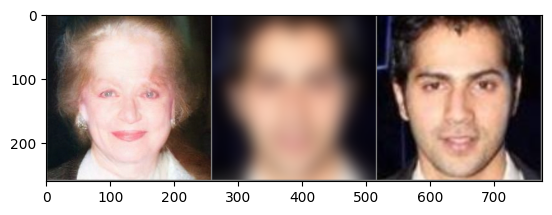

In [39]:
save_image(list_of_evolution_reverse[-1].cpu()/2+0.5, f"ODEdit_enhanced_{0.98}_dt_100.png")
plt.imshow(make_grid([list_of_evolution_reverse[-1],img_tensor, original]).permute(1,2,0).cpu()/2+0.5)

In [23]:
#SDEDIT
sample_step = 3
list_enhanced_sde = {}
list_images = [img_tensor]
model, betas, num_timesteps, logvar = load_model()
for total_noise_levels in range(100,700,100):
    for img in list_images:
        new_img_tensor = img.to(device)
        sde_enhanced = SDEditing(new_img_tensor,scheduler.betas, logvar, unet.to(device), sample_step, total_noise_levels, n=1)
        list_enhanced_sde[total_noise_levels] = sde_enhanced
        save_image(sde_enhanced, f"/home/bastienvandelft/SDEdit_enhanced_{total_noise_levels}_{sample_step}.png")     

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


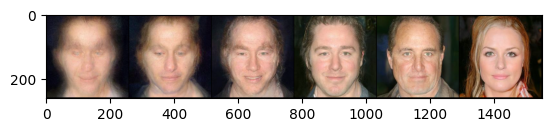

In [24]:
liste_sde = []
for total_noise_levels in range(100,700,100):
    liste_sde.append(list_enhanced_sde[total_noise_levels].squeeze().cpu()/2+0.5)
plt.imshow(make_grid(torch.stack(liste_sde)).permute(1,2,0))
# plt.imshow(list_enhanced_sde[400].squeeze().permute(1,2,0).cpu()/2+0.5)

In [18]:
def corrupt(lq = False, img_path = "/mnt/scitas/bastien/CelebAMask-HQ/CelebA-HQ-img/9999.jpg",corruption = 'spatter', random_sampling = False):
    corruptions_functions = {"shot_noise" : shot_noise, "gaussian_blur" : gaussian_blur, "spatter" : spatter, "fog":fog, "frost":frost, 
                         "snow":snow, "glass_blur":glass_blur, "elastic_transform":elastic_transform, "contrast":contrast, "brightness":brightness,
                        "gaussian_noise":gaussian_noise, "impulse_noise":impulse_noise, "masking_random_color_random":masking_random_color_random,
                        "motion_blur":motion_blur,"jpeg_compression":jpeg_compression, "pixelate":pixelate}
    if lq:
        corruption = corruption
        test_dataset = CelebA(root="/mnt/scitas/bastien/",
                split="test",
                corruption=corruption,
                corruption_severity=5,transform = celeba_transform)
        if random_sampling:
            number = np.random.randint(1,500)
            img_tensor= test_dataset[number][0] 
            original = test_dataset[number][1] 
        else:
            img_tensor= test_dataset[6][0] 
            original = test_dataset[6][1] 
    else:
        if random_sampling:
            number = np.random.randint(1,29999)
            img_path = f"/mnt/scitas/bastien/CelebAMask-HQ/CelebA-HQ-img/{number}.jpg"
            img_pil = PIL.Image.open(img_path).resize([256,256])
            corruption = random.choice(list(corruptions_functions.keys()))
        else:
            img_pil = PIL.Image.open(img_path).resize([256,256])
        corrupted_sample = PIL.Image.fromarray(corruptions_functions[corruption](img_pil, severity  = 5).astype(np.uint8))
        img_tensor = (torch.from_numpy(np.array(corrupted_sample)).permute(2,0,1)/255)*2-1
        original = (torch.from_numpy(np.array(img_pil)).permute(2,0,1)/255)*2-1
    if random_sampling and lq:
        return img_tensor, original, f"LQ_{number}"
    elif random_sampling:
        return img_tensor, original, f"HQ_{number}"
    elif lq:
        return img_tensor, original, f"LQ_base"
    else:
        return img_tensor, original, f"HQ_base"
        
def revert_ode(img_tensor, model):
    inputs = img_tensor.squeeze().unsqueeze(0).to(device)
    list_of_evolution = []
    list_std_encoding = []
    list_mean_encoding = []
    # steps = 100
    # epsilon = 1e-8
    # t_min_var = torch.tensor([1], device=device)
    # min_variance = _extract_into_tensor(1.0 - alphas_cumprod,t_min_var , [1]).item()
    latent_codes = []
    with torch.no_grad():
        latent_codes.append(inputs)
        for t in range(0,ddpm.scheduler.betas.shape[0]-1):
            inputs, std_eps, mean_eps = ddim_step(inputs, model, t, alphas_cumprod, sigma = 0.,clip_denoised=True,dynamic_thresholding = True, device = device, forward=False)
            latent_codes.append(inputs)
            list_std_encoding.append(std_eps)
            list_mean_encoding.append(mean_eps)
            if t % 100 ==0:
                list_of_evolution.append(inputs[0].cpu())
                # plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
                # plt.show()
        list_of_evolution.append(inputs[0].cpu())
        
    # plt.figure(figsize=[20,20])
    # plt.imshow(make_grid(list_of_evolution).permute(1,2,0).cpu()/2+0.5)
    # plt.show()
    latent_code = inputs
    return latent_codes


def editing_with_ode(latent_codes, model, t_start = 1000, std_div = 0.05, epsilon = 1e-8, steps = 20, power =0.5, number_of_sample = 1, alphas_cumprod = alphas_cumprod):
    list_of_evolution_reverse = []
    t_valid = list(range(0, min(1000,t_start)))
    std_recon = 1
    min_variance = 0.0001
    with torch.no_grad():
        inputs = latent_codes[np.max(t_valid)].repeat(number_of_sample, 1,1,1)
        for t in range(1,np.max(t_valid)+1)[::-1]:
            alpha_std = alphas[t]
            if t>39 and t < t_start: #t in t_valid:
                counter = 0
                while std_recon < (1-std_div) or std_recon > (1+std_div):
                    # print(t)
                    inputs,alpha_coef, list_of_stds, list_of_means = langevin_sampling(inputs, model, t, t, alphas_cumprod, steps = steps, epsilon = epsilon,
                                           min_variance = min_variance, clip_prev = False, clip_now = False,dynamic_thresholding=True, device = device, power = power)

                    std_recon = list_of_stds[-1]
                    counter += 1
                    if counter > 100:
                        epsilon = 2*epsilon
                    for h in range(len(inputs)):
                        list_of_evolution_reverse.append(inputs[h].cpu())
                epsilon *= 1
           
            inputs, std_epsilon, mean_epsilon = ddim_step(inputs, model, t, alphas_cumprod, sigma = 0.,
                                                          clip_denoised=True,dynamic_thresholding=True, 
                                                          device = device, forward=True, number_of_sample = number_of_sample)
            std_recon = std_epsilon
            
            if t % 100 ==0:
                for h in range(len(inputs)):
                    list_of_evolution_reverse.append(inputs[h].cpu())

        for h in range(len(inputs)):
            list_of_evolution_reverse.append(inputs[h].cpu())
    return list_of_evolution_reverse

def ODEdit_SDEdit(model,logvar, t_start = 1000, std_div = 0.05, epsilon = 2e-8, steps = 25, power = 0.5, corruption = 'spatter', 
                  lq = False, random_sampling = False, 
                  save = True, device = device):
    
    img_tensor, original, tag = corrupt(lq = lq, corruption = corruption, random_sampling = random_sampling)
    os.makedirs(f'/mnt/scitas/bastien/results/original_tagged/', exist_ok=True)
    os.makedirs(f'/mnt/scitas/bastien/results/corrupted_tagged/{corruption}/', exist_ok=True)
    save_image(original.squeeze().cpu()/2+0.5, f'/mnt/scitas/bastien/results/orginal_tagged/{tag}.png')
    save_image(img_tensor.squeeze().cpu()/2+0.5, f'/mnt/scitas/bastien/results/corrupted_tagged/{corruption}/{tag}.png')
    ## ODEDIT
    latent_codes = revert_ode(img_tensor, model)
    # print('ODE')
    list_of_evolution_reverse = editing_with_ode(latent_codes, model, t_start = t_start, std_div = std_div, 
                                                 epsilon = epsilon, steps = steps, power = power)
    # plt.imshow(list_of_evolution_reverse[-1].permute(1,2,0).cpu()/2+0.5)
    # plt.show()
    if save:
        os.makedirs(f'/mnt/scitas/bastien/results/ode/{corruption}/', exist_ok=True)
        save_image(list_of_evolution_reverse[-1].cpu()/2+0.5, f'/mnt/scitas/bastien/results/ode/{corruption}/{tag}_ode_{std_div}_start_{t_start}.png')  
    
    ## SDEDIT
    # print('SDE')
    sample_step = 2
    list_enhanced_sde = {}
    
    for total_noise_levels in range(100,700,100):
        new_img_tensor = img_tensor.to(device)
        sde_enhanced = SDEditing(new_img_tensor,scheduler.betas, logvar, model.to(device), sample_step, total_noise_levels, n=1)
        list_enhanced_sde[total_noise_levels] = sde_enhanced
        # plt.imshow(sde_enhanced.squeeze().cpu().permute(1,2,0)/2+0.5)
        # plt.show()
        if save:
            os.makedirs(f'/mnt/scitas/bastien/results/sde/{corruption}/', exist_ok=True)
            save_image(sde_enhanced.squeeze().cpu()/2+0.5, f'/mnt/scitas/bastien/results/sde/{corruption}/{tag}_sde_{total_noise_levels}.png')  

    




In [ ]:
corruptions_functions = {"shot_noise" : shot_noise, "gaussian_blur" : gaussian_blur, "spatter" : spatter, "fog":fog, "frost":frost, 
                         "snow":snow, "glass_blur":glass_blur, "elastic_transform":elastic_transform, "contrast":contrast, "brightness":brightness,
                        "gaussian_noise":gaussian_noise, "impulse_noise":impulse_noise, "masking_random_color_random":masking_random_color_random,
                        "motion_blur":motion_blur,"jpeg_compression":jpeg_compression, "pixelate":pixelate}

sde_model, betas, num_timesteps, logvar = load_model()
for lq in [False]:
    for corruption in list(corruptions_functions.keys()):
        print(corruption)
        for t_start in [1000,600,400]:
            for std_div in [0.05, 0.04, 0.03]:
                ODEdit_SDEdit(ddpm.unet,logvar, t_start = t_start, std_div = std_div, epsilon = 2e-8, 
                              steps = 100, power = 0.5, corruption = corruption, 
                              lq = False, random_sampling = False, 
                              save = True, device = device)
                
                

diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

Model loaded
shot_noise
gaussian_blur
spatter
fog
frost
